# Churn Prediction Analysis: Uncovering Who’s Likely to Leave and Why

## Initialization of Python Libraries

We start by importing all the necessary libraries used in this analysis:

- **pandas, numpy** → data manipulation and numerical operations  
- **matplotlib, seaborn** → data visualization  
- **scikit-learn** → preprocessing, feature engineering, modeling, and evaluation  
- **imblearn** → handling imbalanced datasets with resampling techniques  
- **xgboost** → gradient boosting model for churn prediction  
- **shap** → explainable AI for feature importance  
- **k-means & PCA** → clustering and dimensionality reduction  

In [15]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection & preprocessing
from sklearn.model_selection import KFold, cross_val_predict, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Evaluation metrics
from sklearn.metrics import f1_score, confusion_matrix, classification_report

# Handling imbalanced data
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline

# Modeling
import xgboost as xgb

# Explainability
import shap

# Clustering & dimensionality reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

## Data Preparation and Feature Engineering

We begin by preparing user-level features from the four datasets: **sessions, events, billing, and users**.  
The goal is to summarize each dataset at the `user_id` level, then merge them into a single dataset for analysis.

### Steps:
1. **Sessions Summary** → Aggregate user session behavior (activity, diversity, engagement).  
2. **Events Summary** → Aggregate product feature usage and performance metrics.  
3. **Billing Summary** → Aggregate revenue and support-related information.  
4. **Merge All Summaries** → Combine sessions, events, billing with user info.  
5. **Handle Missing Values** → Identify and impute missing data.  
6. **Drop Unwanted Columns** → Keep only relevant modeling features.  

In [16]:
# -------------------------------------------------
#  Load the datasets
# -------------------------------------------------
billing = pd.read_csv("C:/Users/udin0/OneDrive/Documents/GitHub/Mad-Data/Dataset/billing.csv")
events = pd.read_csv("C:/Users/udin0/OneDrive/Documents/GitHub/Mad-Data/Dataset/events.csv")
sessions = pd.read_csv("C:/Users/udin0/OneDrive/Documents/GitHub/Mad-Data/Dataset/sessions.csv")
users = pd.read_csv("C:/Users/udin0/OneDrive/Documents/GitHub/Mad-Data/Dataset/users.csv")


# -------------------------------------------------
# 1️⃣ Sessions summary
#   - Total sessions per user
#   - Device, OS, and country diversity
#   - Average session length
# -------------------------------------------------
sessions_summary = sessions.groupby("user_id").agg(
    total_sessions=("session_length_sec", "count"),
    device_diversity=("device", "nunique"),
    os_diversity=("os", "nunique"),
    country_diversity=("country", "nunique"),
    avg_session_length_sec=("session_length_sec", "mean")
).reset_index()


# -------------------------------------------------
# 2️⃣ Events summary
#   - Total events per user
#   - Number of distinct features and actions
#   - Average event duration & latency
#   - Success rate (mean of success flag)
# -------------------------------------------------
events_summary = events.groupby("user_id").agg(
    total_events=("feature_name", "count"),
    distinct_features=("feature_name", "nunique"),
    distinct_action=("action", "nunique"),
    avg_event_duration_ms=("duration_ms", "mean"),
    avg_latency_ms=("latency_ms", "mean"),
    success_rate=("success", "mean")
).reset_index()


# -------------------------------------------------
# 3️⃣ Billing summary
#   - Average monthly recurring revenue (MRR)
#   - Total active seats across billing cycles
#   - Discounts and overdue invoices
#   - Average support tickets
#   - Most common plan tier
# -------------------------------------------------
def most_common(x):
    return x.value_counts().idxmax()

billing_summary = billing.groupby("user_id").agg(
    avg_mrr=("mrr", "mean"),
    total_active_seats=("active_seats", "sum"),
    discount_count=("discount_applied", "sum"),
    overdue_count=("invoices_overdue", "sum"),
    avg_support_tickets=("support_ticket_count", "mean"),
    most_common_plan=("plan_tier", most_common)
).reset_index()


# -------------------------------------------------
# 4️⃣ Merge all summaries with user dataset
# -------------------------------------------------
merged_data = users.merge(sessions_summary, on="user_id", how="left") \
                   .merge(events_summary, on="user_id", how="left") \
                   .merge(billing_summary, on="user_id", how="left")


# -------------------------------------------------
# 5️⃣ Handle missing values
#    - Identify numeric vs categorical columns
#    - (Optional) Impute numeric with median,
#      categorical with mode
# -------------------------------------------------
numeric_cols = merged_data.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = merged_data.select_dtypes(include=["object", "category"]).columns.tolist()

# Example imputation (currently commented out):
# for col in numeric_cols:
#     merged_data[col] = merged_data[col].fillna(merged_data[col].median())
# for col in cat_cols:
#     merged_data[col] = merged_data[col].fillna(merged_data[col].mode()[0])


# -------------------------------------------------
# 6️⃣ Drop unwanted columns
#    (IDs, metadata, and target variable)
# -------------------------------------------------
drop_cols = ["user_id", "signup_date", "plan_tier", "company_size",
             "region", "industry", "acquisition_channel", "churned_90d"]

merged_data = merged_data.drop(columns=[col for col in drop_cols if col in merged_data.columns])


# -------------------------------------------------
# Final check for missing values
# -------------------------------------------------
print(merged_data.isna().sum())

is_enterprise                 0
churned_30d                   0
downgraded                    0
expansion_event               0
total_sessions            28467
device_diversity          28467
os_diversity              28467
country_diversity         28467
avg_session_length_sec    28467
total_events              42688
distinct_features         42688
distinct_action           42688
avg_event_duration_ms     42688
avg_latency_ms            42688
success_rate              42688
avg_mrr                       0
total_active_seats            0
discount_count                0
overdue_count                 0
avg_support_tickets           0
most_common_plan              0
dtype: int64


## User Distribution by Plan Type and Enterprise Status

This visualization provides a quick overview of the **user base** in terms of:

1. **Plan Type** – how many users are subscribed to Free, Standard, or Premium plans.  
2. **Enterprise Status** – how many users belong to enterprise vs non-enterprise companies.  

Each bar plot also includes **value labels** to indicate the number of users in thousands for easier interpretation.


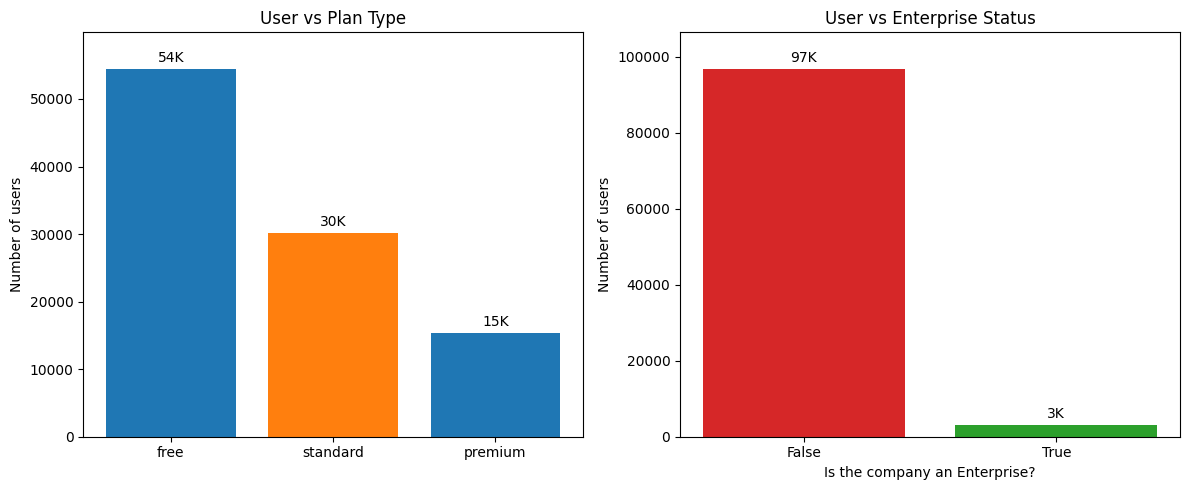

Plan Type Counts:
most_common_plan
free        54425
standard    30219
premium     15356
Name: count, dtype: int64

Enterprise Status Counts:
is_enterprise
False    96794
True      3206
Name: count, dtype: int64


In [17]:
# ------------------------------------------------------------
# Step 1: Create figure with two subplots
# ------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# ------------------------------------------------------------
# Step 2: Plot User vs Plan Type
# ------------------------------------------------------------
plan_counts = merged_data['most_common_plan'].value_counts()  # count users per plan
plan_types = plan_counts.index.tolist()
users_plan = plan_counts.values.tolist()

# Create bar plot
bars1 = ax1.bar(plan_types, users_plan, color=['#1f77b4', '#ff7f0e'])
ax1.set_title('User vs Plan Type')
ax1.set_ylabel('Number of users')
ax1.set_ylim(0, max(users_plan) * 1.1)  # add margin on top

# Add value labels on top of each bar (in thousands)
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + max(users_plan)*0.01,
             f'{height/1000:.0f}K', ha='center', va='bottom')

# ------------------------------------------------------------
# Step 3: Plot User vs Enterprise Status
# ------------------------------------------------------------
enterprise_counts = merged_data['is_enterprise'].value_counts()  # count enterprise vs non-enterprise
enterprise_status = [str(x) for x in enterprise_counts.index.tolist()]
users_enterprise = enterprise_counts.values.tolist()

# Create bar plot
bars2 = ax2.bar(enterprise_status, users_enterprise, color=['#d62728', '#2ca02c'])
ax2.set_title('User vs Enterprise Status')
ax2.set_xlabel('Is the company an Enterprise?')
ax2.set_ylabel('Number of users')
ax2.set_ylim(0, max(users_enterprise) * 1.1)

# Add value labels on top of each bar (in thousands)
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + max(users_enterprise)*0.01,
             f'{height/1000:.0f}K', ha='center', va='bottom')

# ------------------------------------------------------------
# Step 4: Adjust layout and display plots
# ------------------------------------------------------------
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Step 5: Print actual counts for reference
# ------------------------------------------------------------
print("Plan Type Counts:")
print(plan_counts)
print("\nEnterprise Status Counts:")
print(enterprise_counts)


## Correlation Analysis of Numeric Features

To ensure our model is not negatively impacted by multicollinearity, we check for highly correlated features.  
The process includes:  
1. Selecting only numeric columns.  
2. Computing the correlation matrix.  
3. Identifying feature pairs with correlation higher than **0.8** (but less than 1, to exclude self-correlation).  
4. Printing the list of highly correlated pairs for review.  

This helps us decide whether to remove or combine redundant features.


In [18]:
# -------------------------------------------------
# 1️⃣ Select numeric columns
# -------------------------------------------------
numeric_cols = merged_data.select_dtypes(include='number').columns
numeric_data = merged_data[numeric_cols]

# -------------------------------------------------
# 2️⃣ Compute correlation matrix
# -------------------------------------------------
corr_matrix = numeric_data.corr()
print(corr_matrix)

# -------------------------------------------------
# 3️⃣ Define correlation threshold
#     - Here we flag correlations > 0.8
# -------------------------------------------------
threshold = 0.8

# -------------------------------------------------
# 4️⃣ Find pairs of highly correlated features
# -------------------------------------------------
high_corr = (corr_matrix.abs() > threshold) & (corr_matrix.abs() < 1)

# Collect pairs in a list
high_corr_pairs = [
    (col1, col2, corr_matrix.loc[col1, col2])
    for col1 in corr_matrix.columns
    for col2 in corr_matrix.columns
    if high_corr.loc[col1, col2]
]

# -------------------------------------------------
# 5️⃣ Print highly correlated feature pairs
# -------------------------------------------------
print("Highly correlated pairs (> 0.8):")
for pair in high_corr_pairs:
    print(pair)


                        churned_30d  downgraded  expansion_event  \
churned_30d                1.000000   -0.018441         0.038401   
downgraded                -0.018441    1.000000        -0.004177   
expansion_event            0.038401   -0.004177         1.000000   
total_sessions            -0.095180    0.119443        -0.061016   
device_diversity          -0.090489    0.114497        -0.067256   
os_diversity              -0.098627    0.122924        -0.066740   
country_diversity         -0.081381    0.100373        -0.058630   
avg_session_length_sec    -0.000238   -0.003863         0.001930   
total_events              -0.083371    0.093017        -0.043185   
distinct_features         -0.078923    0.084897        -0.038510   
distinct_action           -0.079393    0.083293        -0.039261   
avg_event_duration_ms     -0.005076    0.003968         0.003180   
avg_latency_ms             0.023636   -0.005122         0.003387   
success_rate              -0.002745   -0.001321 

## Dropping Highly Correlated / Irrelevant Features  

Based on the correlation analysis, we remove redundant features that are either:  
- **Highly correlated** with other variables (risk of multicollinearity), or  
- **Less relevant** for modeling.  

The following columns are dropped:  
- `total_sessions`  
- `device_diversity`  
- `avg_session_length_sec`  
- `country_diversity`  
- `success_rate`  

In [19]:
# -------------------------------------------------
# Drop selected features from merged_data
# -------------------------------------------------
merged_data = merged_data.drop(
    ["total_sessions", "device_diversity", "avg_session_length_sec", 
     "country_diversity", "success_rate"], 
    axis=1
)

# -------------------------------------------------
# Print remaining columns for verification
# -------------------------------------------------
print(merged_data.columns)

# -------------------------------------------------
# Check for remaining missing values
# -------------------------------------------------
print(merged_data.isna().sum())

Index(['is_enterprise', 'churned_30d', 'downgraded', 'expansion_event',
       'os_diversity', 'total_events', 'distinct_features', 'distinct_action',
       'avg_event_duration_ms', 'avg_latency_ms', 'avg_mrr',
       'total_active_seats', 'discount_count', 'overdue_count',
       'avg_support_tickets', 'most_common_plan'],
      dtype='object')
is_enterprise                0
churned_30d                  0
downgraded                   0
expansion_event              0
os_diversity             28467
total_events             42688
distinct_features        42688
distinct_action          42688
avg_event_duration_ms    42688
avg_latency_ms           42688
avg_mrr                      0
total_active_seats           0
discount_count               0
overdue_count                0
avg_support_tickets          0
most_common_plan             0
dtype: int64


## Modeling with XGBoost and Feature Importance  

We now build a predictive model to classify whether a customer will churn in the next 30 days.  

### Steps:
1. **Define Features and Target**  
   - `X` → predictor variables (all features except target).  
   - `y` → target variable (`churned_30d`).  

2. **Encode Categorical Variables**  
   - Convert categorical features into numeric values using `LabelEncoder`.  

3. **Train-Test Split**  
   - Split the dataset into 80% training and 20% testing.  

4. **XGBoost Model Training**  
   - Parameters:  
     - `n_estimators=200` (number of trees)  
     - `learning_rate=0.1`  
     - `max_depth=5` (tree depth)  
     - `eval_metric="logloss"` (since classification)  

5. **Feature Importance**  
   - Extract feature importance from the trained model.  
   - Display the most important features driving churn prediction.  

6. **SHAP Analysis**  
   - Use SHAP values for explainable AI to better understand feature contribution.  
   - Display SHAP summary plot for interpretability.  


c:\Users\udin0\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:45:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Top features by importance:
                  feature  importance
14       most_common_plan    0.191882
9                 avg_mrr    0.176154
6         distinct_action    0.083664
8          avg_latency_ms    0.054279
3            os_diversity    0.052760
4            total_events    0.051749
10     total_active_seats    0.051021
7   avg_event_duration_ms    0.048054
2         expansion_event    0.047444
5       distinct_features    0.046981


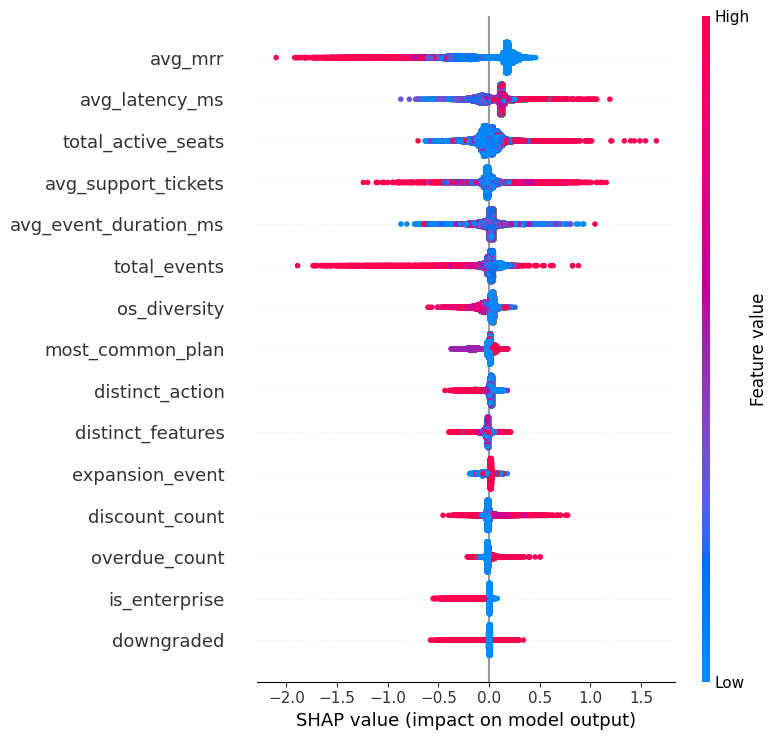

In [20]:
# -------------------------------------------------
# 1️⃣ Define features and target
# -------------------------------------------------
X = merged_data.drop("churned_30d", axis=1)
y = merged_data["churned_30d"]

# -------------------------------------------------
# 2️⃣ Encode categorical columns with LabelEncoder
# -------------------------------------------------
for col in X.select_dtypes(include="object").columns:
    X[col] = LabelEncoder().fit_transform(X[col])

# -------------------------------------------------
# 3️⃣ Train-test split (80/20)
# -------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------------------------------
# 4️⃣ Initialize and train XGBoost classifier
# -------------------------------------------------
model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

model.fit(X_train, y_train)

# -------------------------------------------------
# 5️⃣ Extract feature importance from XGBoost model
# -------------------------------------------------
importance_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": model.feature_importances_
}).sort_values(by="importance", ascending=False)

print("Top features by importance:")
print(importance_df.head(10))  # show top 10 important features

# -------------------------------------------------
# 6️⃣ SHAP values for explainability
# -------------------------------------------------
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# Summary plot of SHAP values (shows global feature impact)
shap.summary_plot(shap_values, X_train)

## Logistic Regression Modeling with Preprocessing & Resampling

In this section, we build a logistic regression model to predict **customer churn**.  
The workflow includes:

1. **Identify categorical & numerical columns**  
   - Separate features into numerical and categorical groups.  
   - This ensures each type of feature undergoes the correct preprocessing.

2. **Preprocessing Pipelines**  
   - **Numeric Features**: Missing values are imputed using the mean and then scaled with `StandardScaler`.  
   - **Categorical Features**: Missing values are imputed with the most frequent value, then encoded with `OneHotEncoder`.

3. **Handling Class Imbalance**  
   - We use **SMOTEENN**, a combination of oversampling (SMOTE) and undersampling (Edited Nearest Neighbors), to balance the dataset.  
   - This step helps the model perform better on the minority class (likely churners).

4. **Model Choice: Logistic Regression**  
   - Logistic regression is a simple yet effective baseline for churn prediction.  
   - We use `liblinear` solver with up to 1000 iterations to ensure convergence.

5. **Pipeline Construction**  
   - A pipeline is created to sequentially apply preprocessing, resampling, and logistic regression.  
   - This ensures clean, reproducible modeling without data leakage.

6. **Model Evaluation (Cross-validation)**  
   - We apply **5-fold cross-validation** to assess model performance.  
   - Predictions are generated using `cross_val_predict` to avoid bias.

7. **Threshold Adjustment**  
   - Instead of the default 0.5 cutoff, we can adjust the probability threshold to optimize recall, precision, or F1 score.  
   - Here, a threshold of **0.5** is used.

8. **Performance Metrics**  
   - **F1 Score**: Balances precision and recall, especially useful for imbalanced data.  
   - **Confusion Matrix**: Shows correct/incorrect classifications.  
   - **Classification Report**: Provides precision, recall, F1-score, and support for each class.

---
**Key Output**:  
- Overall F1 score  
- Confusion matrix  
- Classification report with precision, recall, and F1 for each class


In [21]:
# --------------------------------------------
# Step 1: Identify categorical & numerical columns
# --------------------------------------------
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)

# --------------------------------------------
# Step 2: Preprocessing pipelines
# --------------------------------------------
# For numeric features: impute missing values with mean and scale them
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

# For categorical features: impute missing values with the most frequent value and one-hot encode
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Combine numeric and categorical pipelines into a single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# --------------------------------------------
# Step 3: Define Logistic Regression model
# --------------------------------------------
# Logistic Regression is chosen as a baseline model for churn prediction
log_reg = LogisticRegression(
    max_iter=1000,      # ensure convergence with higher iterations
    solver="liblinear", # suitable for smaller datasets & binary classification
    class_weight=None   # no balancing since we handle imbalance separately
)

# --------------------------------------------
# Step 4: Build Pipeline with Preprocessing + SMOTEENN + Logistic Regression
# --------------------------------------------
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),        # preprocessing for numeric & categorical
    ("smoteenn", SMOTEENN(random_state=42)), # handle class imbalance
    ("model", log_reg)                     # logistic regression model
])

# --------------------------------------------
# Step 5: Cross-validation setup
# --------------------------------------------
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Get cross-validated probabilities for each sample
y_pred_proba = cross_val_predict(pipeline, X, y, cv=cv, method='predict_proba')

# --------------------------------------------
# Step 6: Apply probability threshold for classification
# --------------------------------------------
threshold = 0.5
y_pred = (y_pred_proba[:, 1] >= threshold).astype(int)

# --------------------------------------------
# Step 7: Evaluate Model Performance
# --------------------------------------------
# F1 Score balances precision & recall, useful for imbalanced data
f1 = f1_score(y, y_pred)
print("Overall F1 score:", f1)

# Confusion matrix: breakdown of true/false positives/negatives
cm = confusion_matrix(y, y_pred)
print("\nConfusion Matrix:\n", cm)

# Classification report: precision, recall, F1-score per class
print("\nClassification Report:\n", classification_report(y, y_pred))

Categorical columns: []
Numeric columns: ['downgraded', 'expansion_event', 'os_diversity', 'total_events', 'distinct_features', 'distinct_action', 'avg_event_duration_ms', 'avg_latency_ms', 'avg_mrr', 'total_active_seats', 'discount_count', 'overdue_count', 'avg_support_tickets', 'most_common_plan']
Overall F1 score: 0.22511450130152558

Confusion Matrix:
 [[46134 40905]
 [ 6129  6832]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.53      0.66     87039
           1       0.14      0.53      0.23     12961

    accuracy                           0.53    100000
   macro avg       0.51      0.53      0.44    100000
weighted avg       0.79      0.53      0.61    100000



## K-Means Clustering on User Data

In this section, we apply **K-Means clustering** to group users based on their behavioral and numerical features.  
The workflow includes:
1. Creating a copy of the dataset for clustering.  
2. Handling missing values (numeric → mean, categorical → mode).  
3. Standardizing features for fair clustering.  
4. Using the **Elbow Method** to determine the optimal number of clusters.  
5. Fitting K-Means and assigning cluster labels.  
6. Visualizing clusters with **PCA (2D projection)**.  



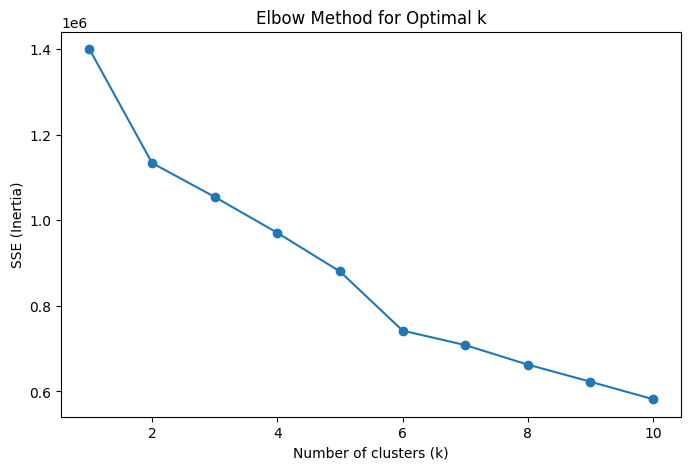

Cluster distribution:
 cluster
2    63653
0    30804
1     5543
Name: count, dtype: int64


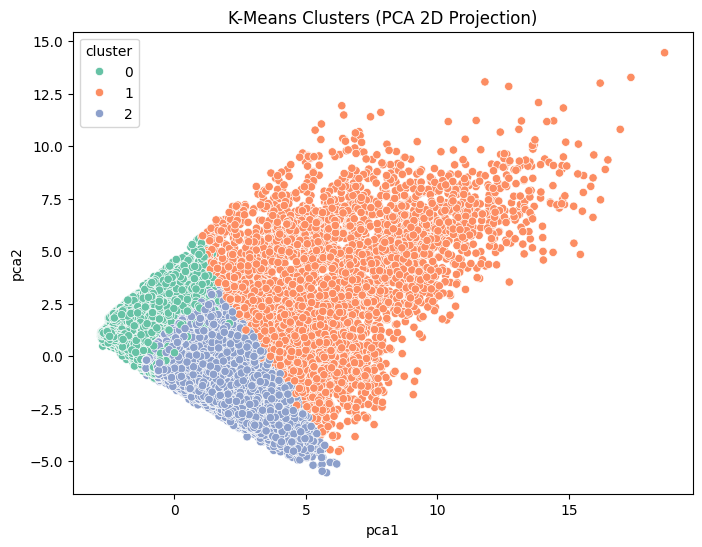

In [22]:
# ------------------------------------------------------------
# Step 1: Create a copy of the dataset for clustering
# ------------------------------------------------------------
cluster_data = merged_data.copy()

# Identify numeric and categorical columns
numeric_cols = cluster_data.select_dtypes(include=np.number).columns.tolist()
categorical_cols = cluster_data.select_dtypes(include=["object", "category"]).columns.tolist()

# ------------------------------------------------------------
# Step 2: Handle missing values
# ------------------------------------------------------------
# Numeric features: impute with mean
cluster_data[numeric_cols] = cluster_data[numeric_cols].fillna(cluster_data[numeric_cols].mean())

# Categorical features: impute with mode
for col in categorical_cols:
    mode_val = cluster_data[col].mode()[0]
    cluster_data[col] = cluster_data[col].fillna(mode_val)

# ------------------------------------------------------------
# Step 3: Select numeric columns for clustering
# ------------------------------------------------------------
X = cluster_data[numeric_cols]

# Standardize features (important for K-Means since it uses distance-based metrics)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ------------------------------------------------------------
# Step 4: Elbow Method to find optimal k
# ------------------------------------------------------------
sse = []  # sum of squared distances (inertia)
k_range = range(1, 11)  # test cluster counts from 1 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

# Plot SSE vs. number of clusters
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("SSE (Inertia)")
plt.title("Elbow Method for Optimal k")
plt.show()

# ------------------------------------------------------------
# Step 5: Fit K-Means with chosen number of clusters
# ------------------------------------------------------------
k = 3  # (example: chosen after inspecting elbow plot)
kmeans = KMeans(n_clusters=k, random_state=42)

# Assign cluster labels to data
cluster_data['cluster'] = kmeans.fit_predict(X_scaled)

# Show number of points in each cluster
print("Cluster distribution:\n", cluster_data['cluster'].value_counts())

# ------------------------------------------------------------
# Step 6: PCA for visualization (reduce to 2D)
# ------------------------------------------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add PCA components to dataframe for plotting
cluster_data['pca1'] = X_pca[:, 0]
cluster_data['pca2'] = X_pca[:, 1]

# Visualize clusters in 2D space
plt.figure(figsize=(8, 6))
sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=cluster_data, palette='Set2')
plt.title("K-Means Clusters (PCA 2D Projection)")
plt.show()


## Analyze Churn Distribution per Cluster

After performing K-Means clustering, we want to understand **how churned customers are distributed across clusters**.  
This helps identify which clusters are at higher risk of churn and may require targeted retention strategies.

### Steps:
1. Define the target column (`churned_30d`).  
2. Loop through each cluster and filter data for that cluster.  
3. Compute and display:
   - Raw counts of churn vs. non-churn customers.  
   - Percentage distribution to understand relative proportions.


In [23]:
# ------------------------------------------------------------
# Step 1: Define target column
# ------------------------------------------------------------
target_col = 'churned_30d'  # target variable indicating churn

# ------------------------------------------------------------
# Step 2: Loop over clusters and analyze target distribution
# ------------------------------------------------------------
for cluster_label in [0, 1, 2]:  # iterate over cluster labels
    # Filter data for the current cluster
    checkcluster = cluster_data[cluster_data['cluster'] == cluster_label]
    
    # Extract target variable for this cluster
    y_cluster = checkcluster[target_col]
    
    # Display raw counts
    print(f"\nCluster {cluster_label} target distribution:")
    print(y_cluster.value_counts())
    
    # Display percentage distribution
    print("Percentage distribution:")
    print(round(y_cluster.value_counts(normalize=True) * 100, 2))


Cluster 0 target distribution:
churned_30d
0    19669
1    11135
Name: count, dtype: int64
Percentage distribution:
churned_30d
0    63.85
1    36.15
Name: proportion, dtype: float64

Cluster 1 target distribution:
churned_30d
0    5199
1     344
Name: count, dtype: int64
Percentage distribution:
churned_30d
0    93.79
1     6.21
Name: proportion, dtype: float64

Cluster 2 target distribution:
churned_30d
0    62171
1     1482
Name: count, dtype: int64
Percentage distribution:
churned_30d
0    97.67
1     2.33
Name: proportion, dtype: float64


## Cluster Profiling: Numeric & Categorical Features

After clustering, we perform **feature-level analysis** to understand how users in each cluster differ.  

### Steps:
1. **Numeric Features**  
   - Compute descriptive statistics (mean, std, min, max, quartiles) per cluster.  
   - Visualize distributions using **boxplots** to identify patterns or outliers.  

2. **Categorical Features**  
   - Display counts per category for each cluster.  
   - Visualize with **bar plots** to compare distribution across clusters.  

This analysis helps identify **characteristics of high-risk clusters** and informs targeted actions.



Cluster 0 - Numeric feature summary:
                         count        mean         std   min         25%  \
churned_30d            30804.0    0.361479    0.480437   0.0    0.000000   
downgraded             30804.0    0.011427    0.106287   0.0    0.000000   
expansion_event        30804.0    0.710849    0.453375   0.0    0.000000   
os_diversity           30804.0    1.907278    0.892070   1.0    1.000000   
total_events           30804.0    2.076164    1.259661   1.0    1.000000   
distinct_features      30804.0    1.370137    0.501348   1.0    1.000000   
distinct_action        30804.0    1.369442    0.481009   1.0    1.000000   
avg_event_duration_ms  30804.0  974.206398  898.537488   6.0  465.458333   
avg_latency_ms         30804.0  261.110565  248.709717  10.0  155.000000   
avg_mrr                30804.0   70.945839  197.470557   0.0    0.000000   
total_active_seats     30804.0  149.342942  252.585761   2.0   25.000000   
discount_count         30804.0    0.400954    0.86

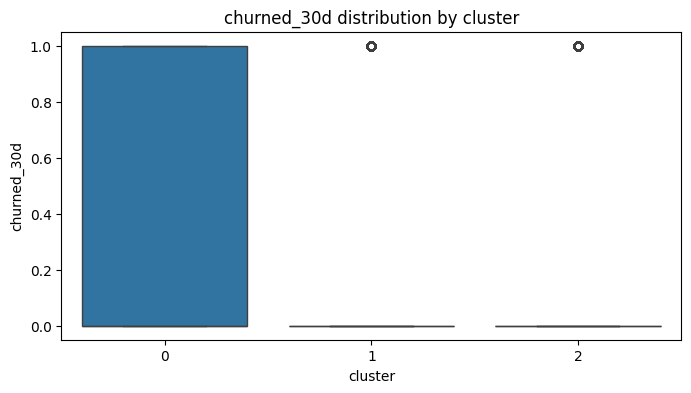

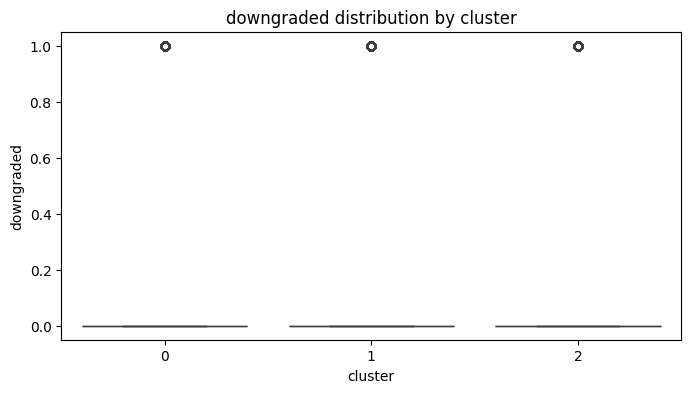

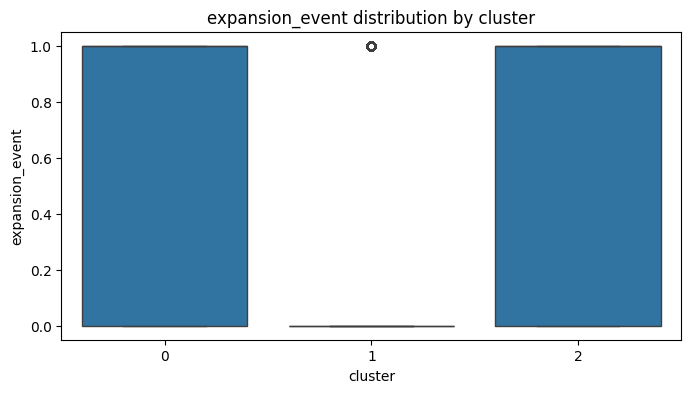

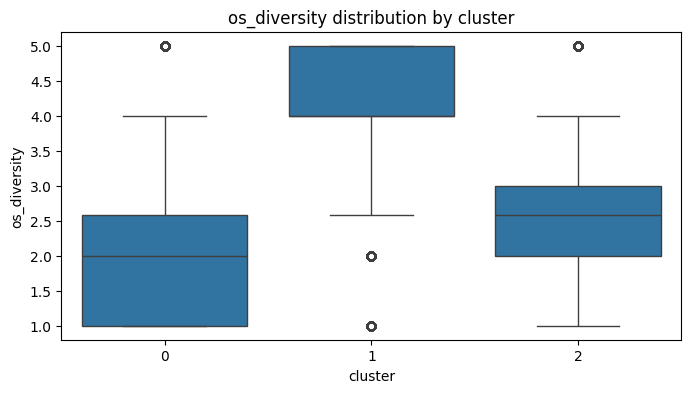

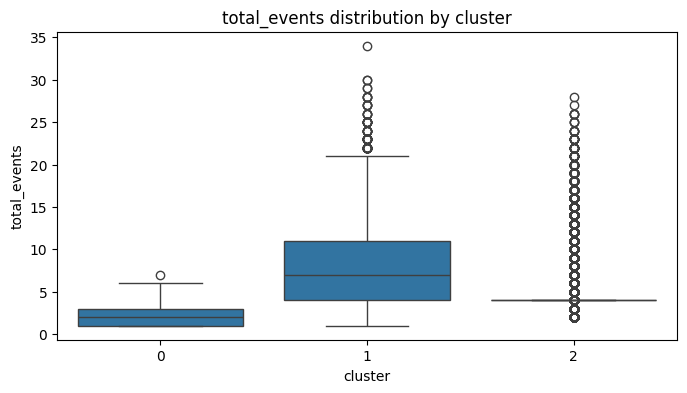

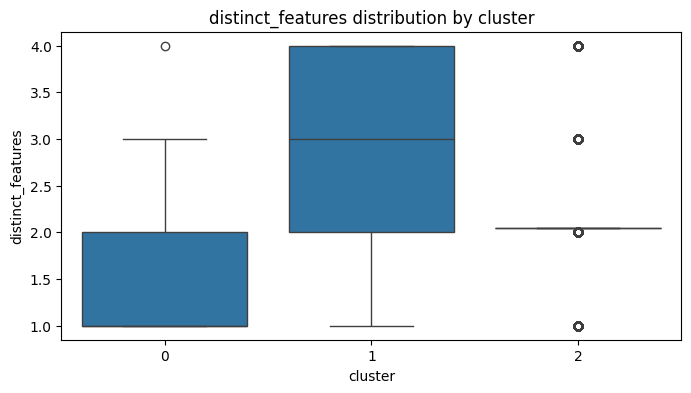

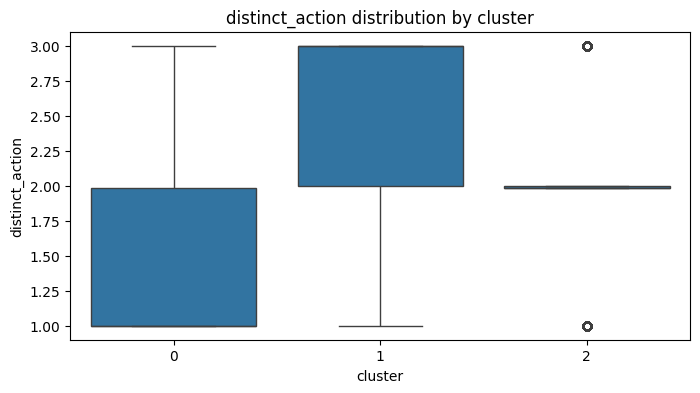

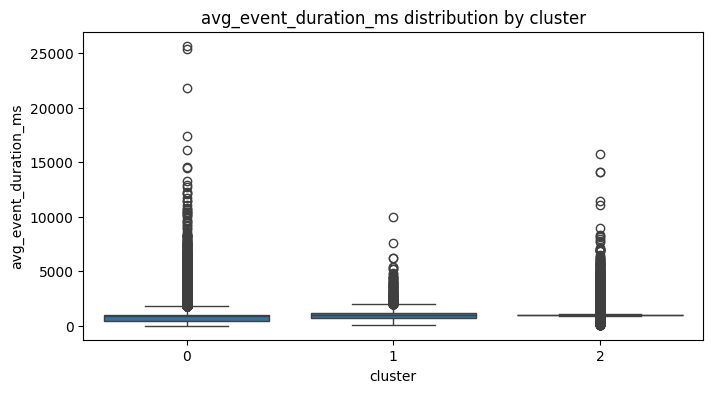

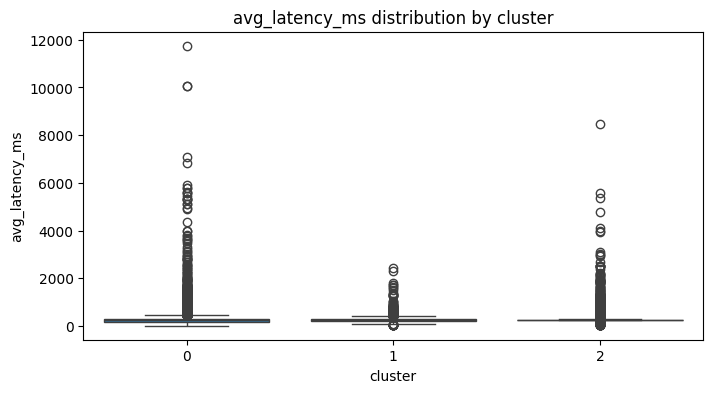

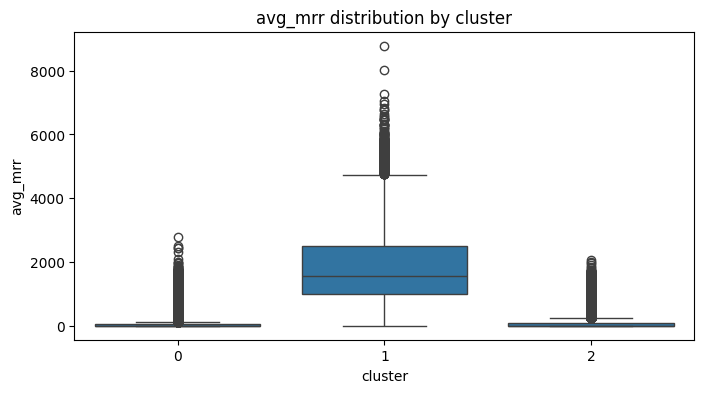

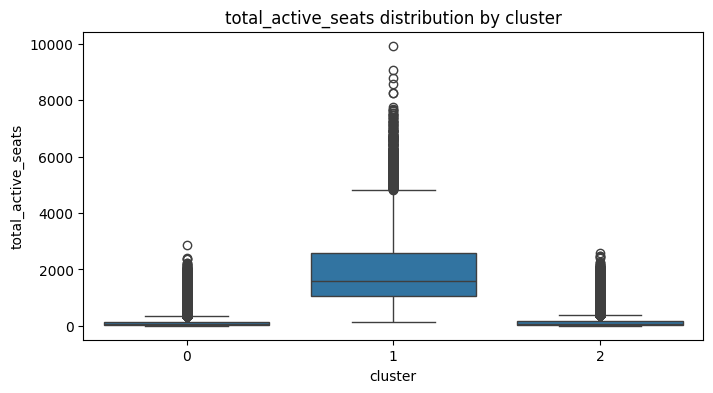

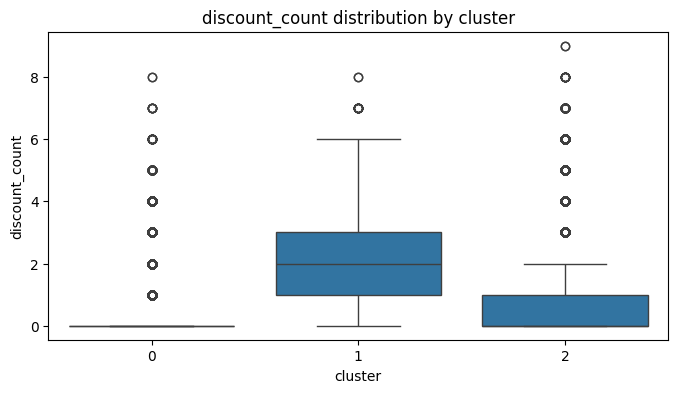

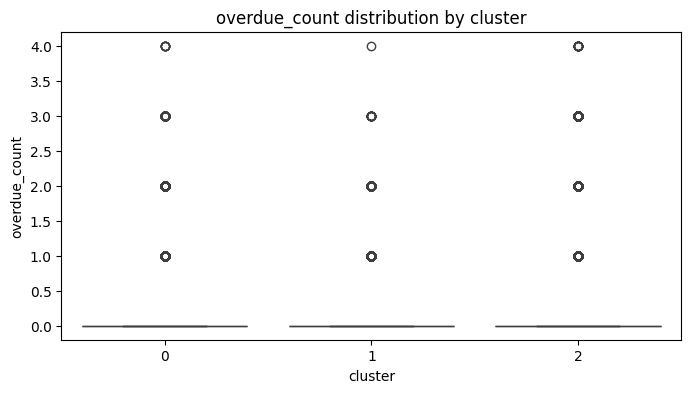

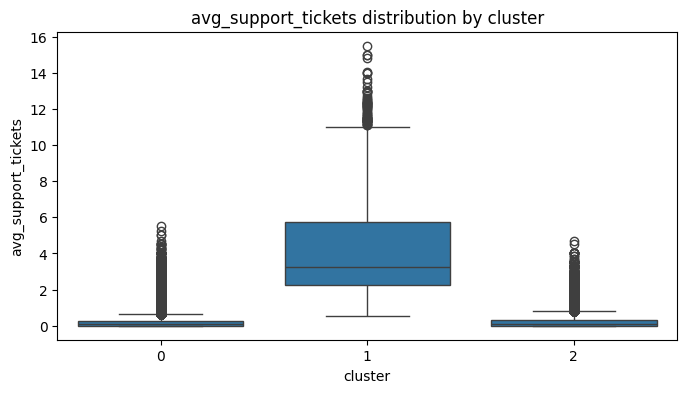

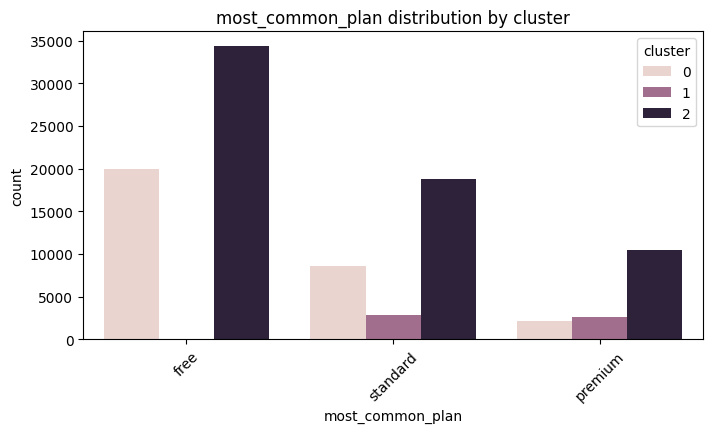

In [24]:
# ------------------------------------------------------------
# Step 1: Numeric feature summary per cluster
# ------------------------------------------------------------
for cluster_label in [0, 1, 2]:
    model_cluster = cluster_data[cluster_data['cluster'] == cluster_label]
    print(f"\nCluster {cluster_label} - Numeric feature summary:")
    # .describe().T gives count, mean, std, min, max, 25%, 50%, 75% for each numeric feature
    print(model_cluster[numeric_cols].describe().T)

# ------------------------------------------------------------
# Step 2: Categorical feature distribution per cluster
# ------------------------------------------------------------
for cluster_label in [0, 1, 2]:
    model_cluster = cluster_data[cluster_data['cluster'] == cluster_label]
    print(f"\nCluster {cluster_label} - Categorical feature distribution:")
    for col in categorical_cols:
        print(f"\nFeature: {col}")
        # Count occurrences of each category
        print(model_cluster[col].value_counts())

# ------------------------------------------------------------
# Step 3: Visualize numeric features with boxplots
# ------------------------------------------------------------
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='cluster', y=col, data=cluster_data)
    plt.title(f"{col} distribution by cluster")
    plt.show()

# ------------------------------------------------------------
# Step 4: Visualize categorical features with barplots
# ------------------------------------------------------------
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, hue='cluster', data=cluster_data)
    plt.title(f"{col} distribution by cluster")
    plt.xticks(rotation=45)  # rotate labels for readability
    plt.show()


## Cluster Pattern Analysis

To understand the characteristics of each cluster, we calculate the **average values** of key features.  
This helps to identify patterns and differences among clusters in terms of usage, OS diversity, and revenue.

**Selected Features:**
- `distinct_features`: Number of different software features used by the user  
- `distinct_action`: Number of different actions performed by the user  
- `total_events`: Total number of events recorded for the user  
- `os_diversity`: Number of different operating systems used by the user  
- `avg_mrr`: Average monthly recurring revenue paid by the user


In [25]:
# ------------------------------------------------------------
# Step 1: Define features to analyze for cluster patterns
# ------------------------------------------------------------
features_to_check = [
    'distinct_features',
    'distinct_action',
    'total_events',
    'os_diversity',
    'avg_mrr'
]

# ------------------------------------------------------------
# Step 2: Group data by cluster and compute mean of selected features
# ------------------------------------------------------------
cluster_means = cluster_data.groupby('cluster')[features_to_check].mean()

# ------------------------------------------------------------
# Step 3: Display cluster patterns
# ------------------------------------------------------------
print("Average values of key features by cluster:")
print(cluster_means)


Average values of key features by cluster:
         distinct_features  distinct_action  total_events  os_diversity  \
cluster                                                                   
0                 1.370137         1.369442      2.076164      1.907278   
1                 2.907547         2.639389      8.158859      4.170320   
2                 2.301439         2.218797      4.708133      2.774509   

             avg_mrr  
cluster               
0          70.945839  
1        1923.497461  
2          90.461755  


## Cluster-Specific Logistic Regression Modeling

We now build **separate logistic regression models for each cluster** to account for differences in user behavior and churn patterns.  

### Workflow:
1. **Define target column** (`churned_30d`).  
2. **Loop through clusters** (0, 1, 2) to build individual models.  
3. **Preprocessing per cluster**:  
   - Numeric features: impute missing values with mean and scale.  
   - Categorical features: impute missing values with mode and one-hot encode.  
4. **Handle class imbalance** using **SMOTEENN** and `class_weight="balanced"`.  
5. **Train logistic regression** via a pipeline (preprocessing + resampling + model).  
6. **Evaluate with 5-fold cross-validation**:  
   - Compute predicted probabilities.  
   - Apply a custom threshold (0.5) to classify churn.  
   - Calculate F1 score, confusion matrix, and classification report.  
7. **Store models and metrics** for each cluster for later analysis or deployment.


In [26]:
# ------------------------------------------------------------
# Step 1: Define target column
# ------------------------------------------------------------
target_col = 'churned_30d'  # target variable

# Dictionaries to store trained pipelines and evaluation metrics
cluster_models = {}
cluster_metrics = {}

# ------------------------------------------------------------
# Step 2: Loop over each cluster to build individual models
# ------------------------------------------------------------
for cluster_label in [0, 1, 2]:
    print(f"\nProcessing cluster {cluster_label}...")
    
    # Filter data for the current cluster
    final_cluster = cluster_data[cluster_data['cluster'] == cluster_label]
    X_cluster = final_cluster.drop(columns=[target_col, 'cluster', 'pca1', 'pca2'])
    y_cluster = final_cluster[target_col]
    
    # Identify numeric & categorical features for preprocessing
    categorical_cols = X_cluster.select_dtypes(include=["object", "category"]).columns.tolist()
    numeric_cols = X_cluster.select_dtypes(include=["int64", "float64"]).columns.tolist()
    
    # ------------------------------------------------------------
    # Step 3: Preprocessing pipelines
    # ------------------------------------------------------------
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])
    
    preprocessor = ColumnTransformer(transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ])
    
    # ------------------------------------------------------------
    # Step 4: Logistic Regression model
    # ------------------------------------------------------------
    log_reg = LogisticRegression(
        max_iter=1000,
        solver="liblinear",
        class_weight="balanced"  # handle imbalanced data
    )
    
    # ------------------------------------------------------------
    # Step 5: Full pipeline with SMOTEENN
    # ------------------------------------------------------------
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("smoteenn", SMOTEENN(random_state=42)),
        ("model", log_reg)
    ])
    
    # ------------------------------------------------------------
    # Step 6: Cross-validation setup
    # ------------------------------------------------------------
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Predict probabilities with cross-validation
    y_pred_proba = cross_val_predict(pipeline, X_cluster, y_cluster, cv=cv, method='predict_proba')
    
    # Apply threshold to convert probabilities into class predictions
    threshold = 0.5
    y_pred = (y_pred_proba[:, 1] >= threshold).astype(int)
    
    # ------------------------------------------------------------
    # Step 7: Compute evaluation metrics
    # ------------------------------------------------------------
    f1 = f1_score(y_cluster, y_pred)
    cm = confusion_matrix(y_cluster, y_pred)
    report = classification_report(y_cluster, y_pred)
    
    # Print metrics for current cluster
    print(f"\nCluster {cluster_label} F1 Score: {f1}")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", report)
    
    # Store trained pipeline and metrics
    cluster_models[cluster_label] = pipeline
    cluster_metrics[cluster_label] = {"f1": f1, "cm": cm, "report": report}

print("\nLogistic Regression pipelines trained for all clusters!")


Processing cluster 0...

Cluster 0 F1 Score: 0.7946540577052977
Confusion Matrix:
 [[18313  1356]
 [ 2900  8235]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.93      0.90     19669
           1       0.86      0.74      0.79     11135

    accuracy                           0.86     30804
   macro avg       0.86      0.84      0.85     30804
weighted avg       0.86      0.86      0.86     30804


Processing cluster 1...

Cluster 1 F1 Score: 0.13821138211382114
Confusion Matrix:
 [[2795 2404]
 [ 140  204]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.54      0.69      5199
           1       0.08      0.59      0.14       344

    accuracy                           0.54      5543
   macro avg       0.52      0.57      0.41      5543
weighted avg       0.90      0.54      0.65      5543


Processing cluster 2...

Cluster 2 F1 Score: 0.1381037956760878
Confus

## Cluster 0: Logistic Regression Feature Importance

For **Cluster 0**, we analyze which features contribute the most to predicting churn.  
We use the **logistic regression coefficients** after preprocessing and handling class imbalance with **SMOTEENN**.  

### Workflow:
1. Filter data for cluster 0.  
2. Define features (`X`) and target (`y`).  
3. Identify numeric and categorical columns.  
4. Build preprocessing pipelines:  
   - Numeric → impute missing values and scale.  
   - Categorical → impute missing values and one-hot encode.  
5. Fit a **pipeline** with preprocessing + SMOTEENN + Logistic Regression.  
6. Extract **feature names** after preprocessing.  
7. Retrieve **logistic regression coefficients**.  
8. Rank features by **absolute coefficient magnitude** to identify top drivers of churn.

In [27]:
# ------------------------------------------------------------
# Step 1: Select data for Cluster 0
# ------------------------------------------------------------
cluster_0_data = cluster_data[cluster_data['cluster'] == 0]

# ------------------------------------------------------------
# Step 2: Define features and target
# ------------------------------------------------------------
target_col = 'churned_30d'
X = cluster_0_data.drop(columns=[target_col, 'cluster', 'pca1', 'pca2'])
y = cluster_0_data[target_col]

# ------------------------------------------------------------
# Step 3: Identify categorical and numerical columns
# ------------------------------------------------------------
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# ------------------------------------------------------------
# Step 4: Build preprocessing pipelines
# ------------------------------------------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# ------------------------------------------------------------
# Step 5: Logistic Regression with SMOTEENN for imbalance
# ------------------------------------------------------------
log_reg = LogisticRegression(
    max_iter=1000,
    solver="liblinear",
    class_weight="balanced"
)

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("smoteenn", SMOTEENN(random_state=42)),
    ("model", log_reg)
])

# Fit the pipeline on Cluster 0 data
pipeline.fit(X, y)

# ------------------------------------------------------------
# Step 6: Extract feature names after preprocessing
# ------------------------------------------------------------
feature_names_num = numeric_cols
if categorical_cols:
    feature_names_cat = pipeline.named_steps['preprocessor'] \
        .named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_cols)
    feature_names = list(feature_names_num) + list(feature_names_cat)
else:
    feature_names = feature_names_num

# ------------------------------------------------------------
# Step 7: Get logistic regression coefficients
# ------------------------------------------------------------
coefficients = pipeline.named_steps['model'].coef_[0]

# ------------------------------------------------------------
# Step 8: Create DataFrame for feature importance
# ------------------------------------------------------------
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
})

# Sort features by absolute coefficient magnitude
coef_df['abs_coef'] = coef_df['coefficient'].abs()
coef_df_sorted = coef_df.sort_values(by='abs_coef', ascending=False)

# Display top 10 features
print("Top features by coefficient magnitude for Cluster 0:")
print(coef_df_sorted[['feature', 'coefficient']].head(10))

Top features by coefficient magnitude for Cluster 0:
                      feature  coefficient
3                total_events     1.544486
14   most_common_plan_premium    -1.393783
4           distinct_features     0.924809
5             distinct_action     0.668047
2                os_diversity     0.403530
15  most_common_plan_standard    -0.396265
13      most_common_plan_free     0.330755
9          total_active_seats    -0.217035
7              avg_latency_ms     0.195799
10             discount_count     0.184540


## Cluster-Wise XGBoost Modeling and SHAP Feature Importance

### Workflow Overview:

1. **Loop over clusters (0, 1, 2)**:
    - Filter data for the cluster.
    - Split into features (`X_cluster`) and target (`y_cluster`).
    - Identify categorical and numerical columns.
    - Build preprocessing pipelines:
        - Numeric → mean imputation + standard scaling.
        - Categorical → mode imputation + one-hot encoding.
    - Fit an **XGBoost classifier** in a pipeline with preprocessing.
    - Perform **5-fold cross-validation**.
    - Compute predictions and **evaluation metrics** (F1 score, confusion matrix, classification report).
    - Save each cluster’s pipeline and metrics.

2. **SHAP Analysis for Cluster 0**:
    - Fit the saved pipeline for Cluster 0.
    - Transform features using the preprocessing pipeline.
    - Compute **SHAP values** to explain model predictions.
    - Identify and display **top 5 features** with the highest mean SHAP values.



Processing cluster 0...


c:\Users\udin0\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:49:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\udin0\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:49:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\udin0\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:49:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are


Cluster 0 F1 Score: 0.8379054970272244
Confusion Matrix:
 [[19663     6]
 [ 3102  8033]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.93     19669
           1       1.00      0.72      0.84     11135

    accuracy                           0.90     30804
   macro avg       0.93      0.86      0.88     30804
weighted avg       0.91      0.90      0.89     30804


Processing cluster 1...


c:\Users\udin0\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:49:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\udin0\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:49:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\udin0\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:49:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are


Cluster 1 F1 Score: 0.0
Confusion Matrix:
 [[5197    2]
 [ 344    0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      5199
           1       0.00      0.00      0.00       344

    accuracy                           0.94      5543
   macro avg       0.47      0.50      0.48      5543
weighted avg       0.88      0.94      0.91      5543


Processing cluster 2...


c:\Users\udin0\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:49:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\udin0\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:49:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\udin0\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:49:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are


Cluster 2 F1 Score: 0.0
Confusion Matrix:
 [[62170     1]
 [ 1482     0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     62171
           1       0.00      0.00      0.00      1482

    accuracy                           0.98     63653
   macro avg       0.49      0.50      0.49     63653
weighted avg       0.95      0.98      0.97     63653


Computing SHAP values for cluster 0...


c:\Users\udin0\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:49:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


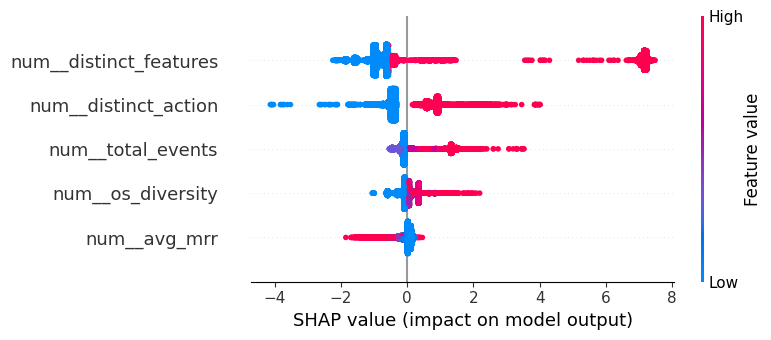


Top 5 features by mean SHAP value (Cluster 0):
                   feature  mean_shap
4   num__distinct_features   1.046813
3        num__total_events   0.240859
2        num__os_diversity   0.047649
5     num__distinct_action   0.029846
9  num__total_active_seats  -0.021614


In [28]:
# ------------------------------------------------------------
# Step 1: Initialize dictionaries to store models and metrics
# ------------------------------------------------------------
cluster_models = {}
cluster_metrics = {}
target_col = 'churned_30d'

# ------------------------------------------------------------
# Step 2: Loop over clusters to train XGBoost models
# ------------------------------------------------------------
for cluster_label in [0, 1, 2]:
    print(f"\nProcessing cluster {cluster_label}...")
    
    # Select data for the cluster
    final_cluster = cluster_data[cluster_data['cluster'] == cluster_label]
    X_cluster = final_cluster.drop(columns=[target_col, 'cluster', 'pca1', 'pca2'])
    y_cluster = final_cluster[target_col]
    
    # Identify categorical & numerical columns
    categorical_cols = X_cluster.select_dtypes(include=["object", "category"]).columns.tolist()
    numeric_cols = X_cluster.select_dtypes(include=["int64", "float64"]).columns.tolist()
    
    # Preprocessing pipelines
    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])
    
    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])
    
    preprocessor = ColumnTransformer([
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ])
    
    # XGBoost classifier
    xgb_model = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric='auc',
        random_state=42
    )
    
    # Full pipeline
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", xgb_model)
    ])
    
    # 5-fold cross-validation predictions
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    y_pred_proba = cross_val_predict(pipeline, X_cluster, y_cluster, cv=cv, method='predict_proba')
    
    # Apply threshold
    threshold = 0.5
    y_pred = (y_pred_proba[:, 1] >= threshold).astype(int)
    
    # Compute metrics
    f1 = f1_score(y_cluster, y_pred)
    cm = confusion_matrix(y_cluster, y_pred)
    report = classification_report(y_cluster, y_pred)
    
    print(f"\nCluster {cluster_label} F1 Score: {f1}")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", report)
    
    # Save model and metrics
    cluster_models[cluster_label] = pipeline
    cluster_metrics[cluster_label] = {"f1": f1, "cm": cm, "report": report}

# ------------------------------------------------------------
# Step 3: SHAP values for Cluster 0
# ------------------------------------------------------------
print("\nComputing SHAP values for cluster 0...")

cluster_0_data = cluster_data[cluster_data['cluster'] == 0]
X0 = cluster_0_data.drop(columns=[target_col, 'cluster', 'pca1', 'pca2'])
y0 = cluster_0_data[target_col]

# Fit pipeline for Cluster 0
pipeline_0 = cluster_models[0]
pipeline_0.fit(X0, y0)

# Transform features using preprocessing
X0_preprocessed = pipeline_0.named_steps['preprocessor'].transform(X0)

# Initialize SHAP explainer and compute SHAP values
explainer = shap.Explainer(pipeline_0.named_steps['model'])
shap_values = explainer(X0_preprocessed)

# Summary plot (top 5 features)
shap.summary_plot(shap_values, X0_preprocessed, 
                  feature_names=pipeline_0.named_steps['preprocessor'].get_feature_names_out(),
                  max_display=5)

# ------------------------------------------------------------
# Step 4: Extract top features by mean SHAP value
# ------------------------------------------------------------
feature_names = pipeline_0.named_steps['preprocessor'].get_feature_names_out()
shap_array = shap_values.values
mean_shap = shap_array.mean(axis=0)

shap_df = pd.DataFrame({
    "feature": feature_names,
    "mean_shap": mean_shap
})

# Sort by absolute value and select top 5
top5_shap = shap_df.reindex(shap_df['mean_shap'].abs().sort_values(ascending=False).index).head(5)
print("\nTop 5 features by mean SHAP value (Cluster 0):")
print(top5_shap)